In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.read_csv("assignment_train.csv")
test = pd.read_csv("assignment_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


## Задание на повторение:
#### Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.
### Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

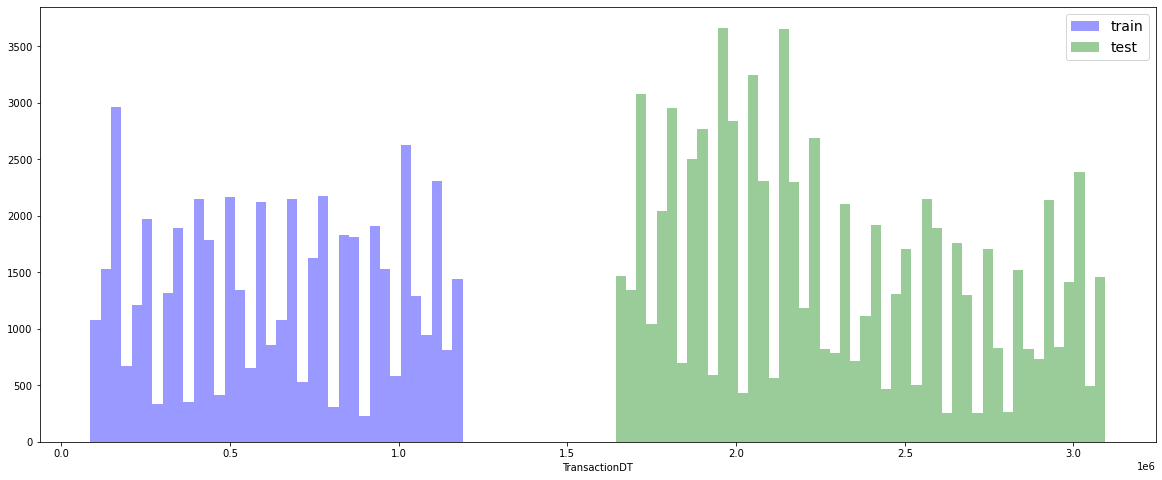

In [65]:
plt.figure(figsize=(20,10))
sns.distplot(train['TransactionDT'], kde=False, color="Blue", label="train")
sns.distplot(test['TransactionDT'], kde=False, color="Green", label="test")
plt.legend(loc="best", fontsize=14)

По графику видно, что данные разбиты по времени - тестовые данные новее данных для обучения. При этом между данными есть зазор по времени, природа которого не ясна.
Валидацию надо проводить с учётом временной зависимости - данные для обучения на собственно трейн и валидацию я бы разбил бы по времени - сначала трейн, потом валид.

### Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

Text(0.5, 1.0, 'Test')

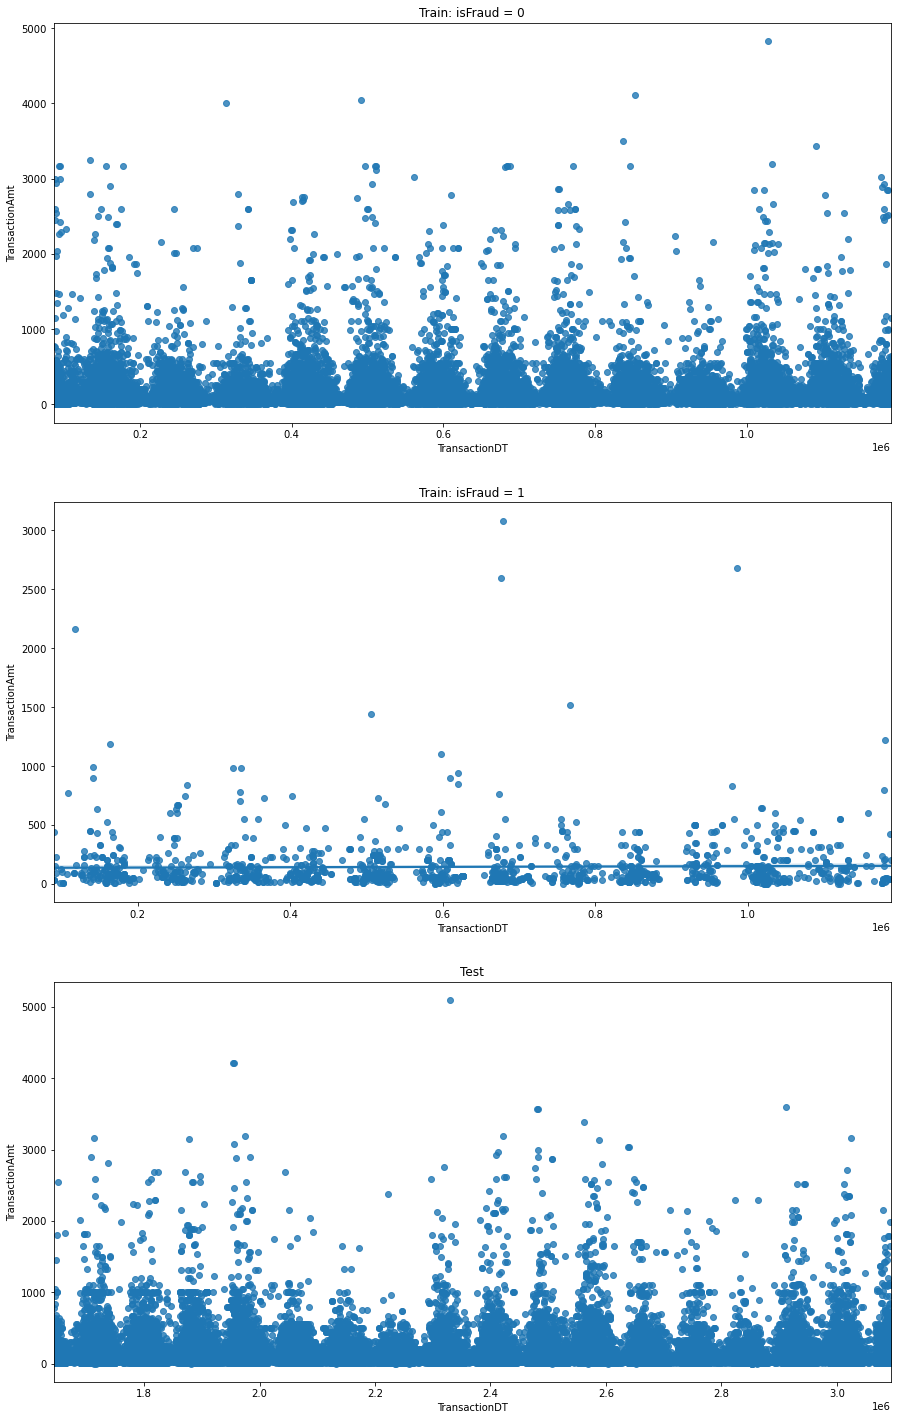

In [81]:

fig, axes = plt.subplots(3, 1, figsize=(15, 25))
sns.regplot(
    x="TransactionDT",
    y="TransactionAmt",
    ax=axes[0],
    data=train[train['isFraud'] == 0],
    scatter=True
).set_title("Train: isFraud = 0")
sns.regplot(
    x="TransactionDT",
    y="TransactionAmt",
    ax=axes[1],
    data=train[train['isFraud'] == 1],
    scatter=True
).set_title("Train: isFraud = 1")
sns.regplot(
    x="TransactionDT",
    y="TransactionAmt",
    ax=axes[2],
    data=test,
    scatter=True
).set_title("Test")

Видно, что большинство транзакций меньше 1000, причём среди плохих операций транзакции ещё меньше и выбросов меньше. Так же в транзакциях наблюдается какой-то периодический тренд - полагаю, что на выходных транзакций проводится больше.

### Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

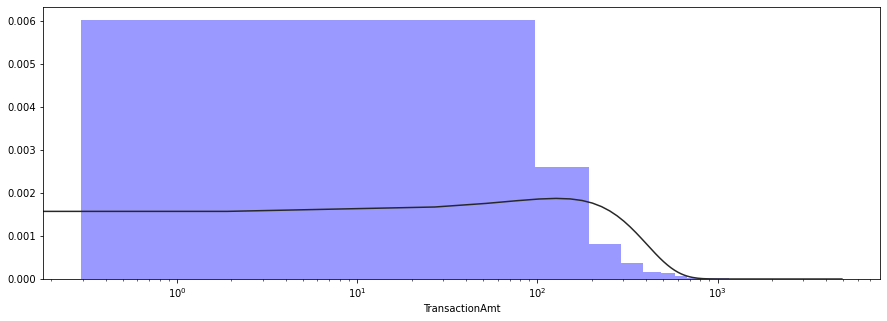

In [85]:
fig = plt.figure(figsize=(15, 5))
sns.distplot(train["TransactionAmt"], kde=False, color="blue", fit=st.norm).set_xscale('log')

Как-то не очень похоже на нормальное распределение ни в трейне...

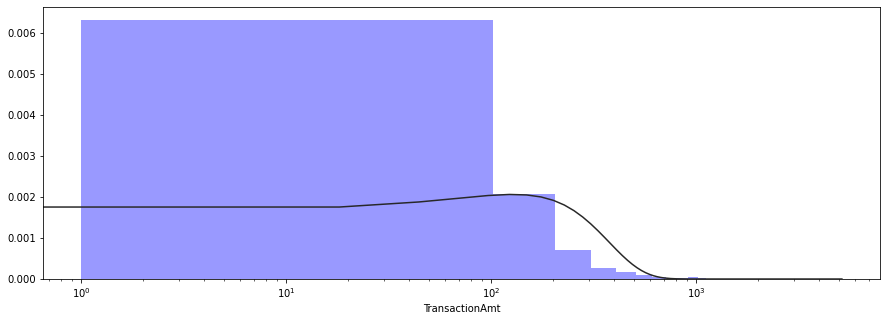

In [86]:
fig = plt.figure(figsize=(15, 5))
sns.distplot(test["TransactionAmt"], kde=False, color="blue", fit=st.norm).set_xscale('log')

Ни в тесте. Распределения выглядят похожими, только на тесте снижение более резкое.

### Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [100]:
categorical_features = ["ProductCD", "card4", "card6"]

<Figure size 1080x720 with 0 Axes>

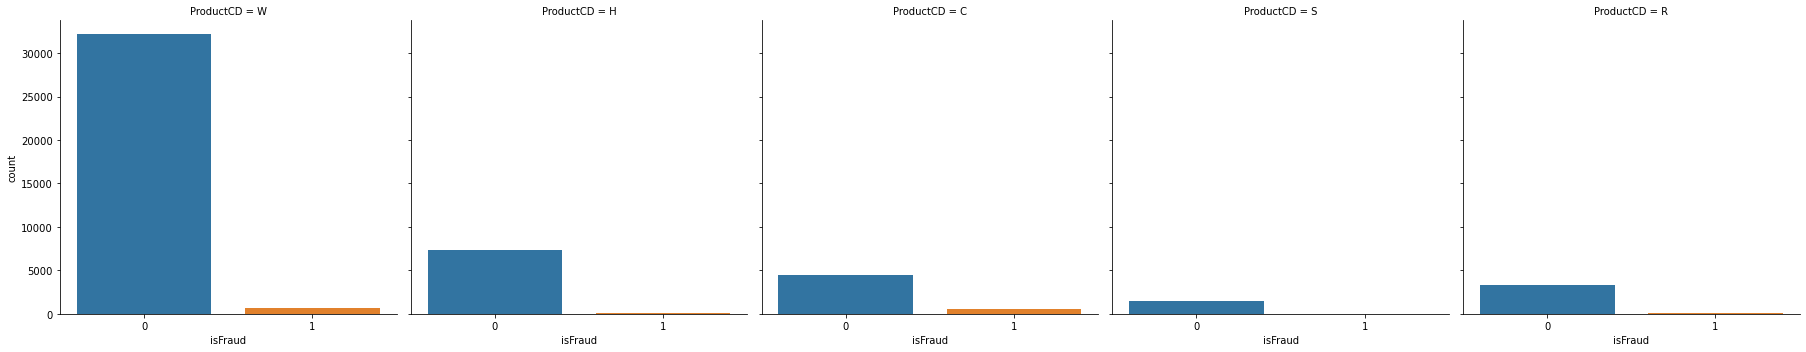

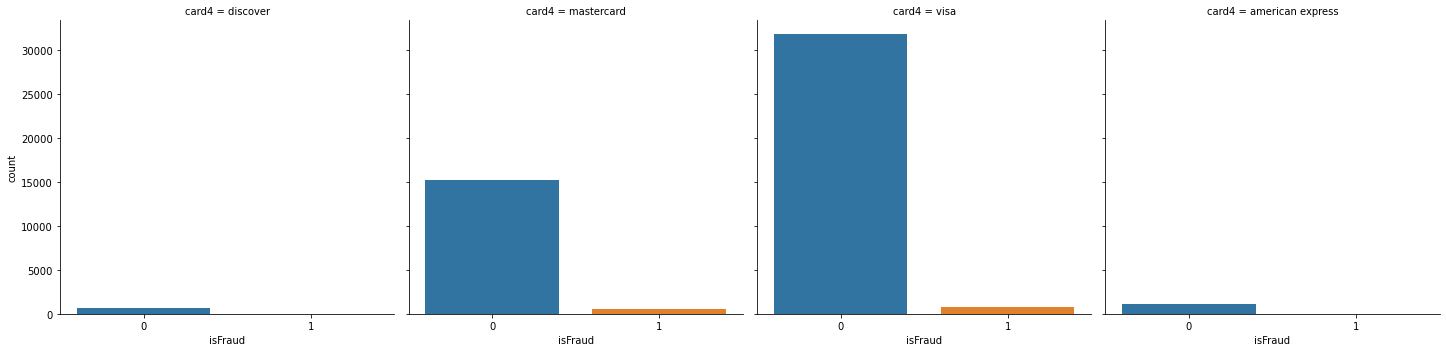

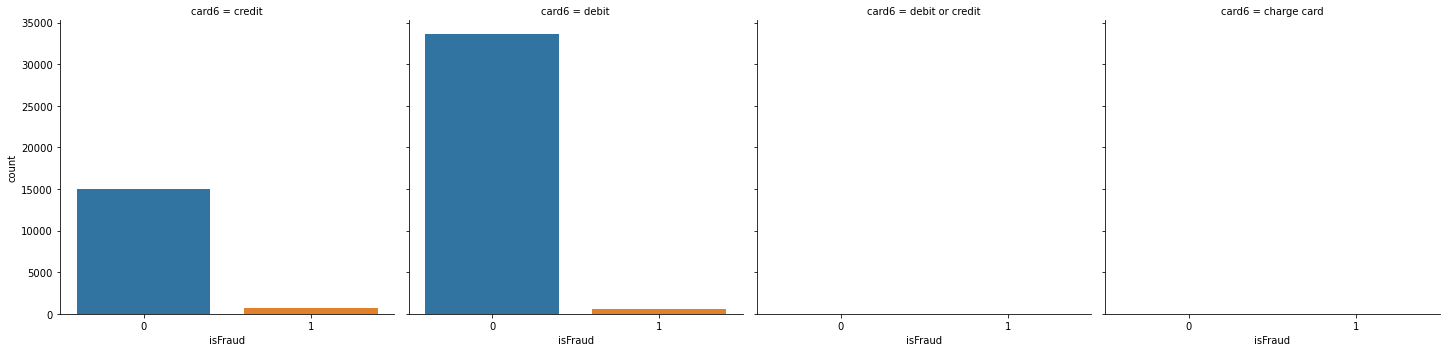

In [122]:
fig = plt.figure(figsize=(15, 10))
for num, feature in enumerate(categorical_features):
    sns.catplot(x="isFraud", data=train, kind="count", col=feature)

На графиках видно, что плохих транзакций ощутимо меньше (что не может не радовать). При этом можно отметить, что чем популярнее вид транзакции, тем больше плохих операций на ней, но некоторые типы выделяются более большой долей плохих транзакций - к примеру в целом транзакций c ProductCD = C меньше, но плохих транзакций на ней визуально столько же, сколько и для транзакций с ProductCD = W, иными словами ProductCD = C популярнее для мошейников. Аналогично card6 = credit очень популярно у мошейников.

## Основное задание:
#### Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [123]:
train.sort_values("TransactionID", inplace=True)
X_train = train.drop("isFraud", axis=1)
y_train = train["isFraud"]

In [124]:
test.sort_values("TransactionID", inplace=True)
X_test = test.drop("isFraud", axis=1)
y_test = test["isFraud"]

In [125]:
from sklearn.model_selection import train_test_split

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=42)

In [172]:
numerical_features = X_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

In [173]:
eval_set = [(X_valid[numerical_features], y_valid)]
model = xgb.XGBClassifier(n_estimators=100, n_jobs=8)

In [175]:
model.fit(X_train[numerical_features],
            y_train,
            eval_metric='auc',
            eval_set=eval_set,
            early_stopping_rounds=5)

[0]	validation_0-auc:0.74845
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.83951
[2]	validation_0-auc:0.83884
[3]	validation_0-auc:0.84197
[4]	validation_0-auc:0.84068
[5]	validation_0-auc:0.86289
[6]	validation_0-auc:0.86317
[7]	validation_0-auc:0.86624
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86961
[10]	validation_0-auc:0.86539
[11]	validation_0-auc:0.85550
[12]	validation_0-auc:0.86126
[13]	validation_0-auc:0.86669
[14]	validation_0-auc:0.87118
[15]	validation_0-auc:0.87264
[16]	validation_0-auc:0.87851
[17]	validation_0-auc:0.87957
[18]	validation_0-auc:0.87893
[19]	validation_0-auc:0.88055
[20]	validation_0-auc:0.88195
[21]	validation_0-auc:0.88368
[22]	validation_0-auc:0.88509
[23]	validation_0-auc:0.88501
[24]	validation_0-auc:0.88247
[25]	validation_0-auc:0.88366
[26]	validation_0-auc:0.88507
[27]	validation_0-auc:0.89031
[28]	validation_0-auc:0.89049
[29]	validation_0-auc:0.89279
[30]	validation_0-auc:0.89229
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [176]:
y_train_pred = model.predict_proba(X_train[numeric_features])
roc_auc_score(y_train, y_train_pred[:, 1])

0.9714793467055961

In [177]:
y_valid_pred = model.predict_proba(X_valid[numeric_features])
roc_auc_score(y_valid, y_valid_pred[:, 1])

0.892787381693249

In [178]:
y_test_pred = model.predict_proba(X_test[numeric_features])
roc_auc_score(y_test, y_test_pred[:, 1])

0.8510529116217853

На тех данных, на которых модель обучалась, получился результат в 97%, при этом на валидационных и на тестовых данных - 89% и 85% соответственно. Похоже, что модель сильно обучилась на обучающем датасете, но разница между валидом и тестом в пределах 5%, что хорошо

### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [185]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.4, random_state=42)
X_valid, X_valid_test, y_valid, y_valid_test = train_test_split(X_valid, y_valid, shuffle=False, test_size=0.5, random_state=42)
eval_set = [(X_valid[numeric_features], y_valid),
            (X_valid_test[numeric_features], y_valid_test)]
model = xgb.XGBClassifier(n_estimators=100, n_jobs=8)

In [186]:
model.fit(X_train[numeric_features],
            y_train,
            eval_metric='auc',
            eval_set=eval_set,
            early_stopping_rounds=5)

[0]	validation_0-auc:0.76793	validation_1-auc:0.79086
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.78612	validation_1-auc:0.81508
[2]	validation_0-auc:0.80807	validation_1-auc:0.83740
[3]	validation_0-auc:0.80778	validation_1-auc:0.84062
[4]	validation_0-auc:0.80769	validation_1-auc:0.83941
[5]	validation_0-auc:0.82198	validation_1-auc:0.85740
[6]	validation_0-auc:0.82195	validation_1-auc:0.85572
[7]	validation_0-auc:0.82044	validation_1-auc:0.84916
[8]	validation_0-auc:0.82031	validation_1-auc:0.85208
[9]	validation_0-auc:0.81717	validation_1-auc:0.85141
[10]	validation_0-auc:0.81937	validation_1-auc:0.85281
Stopping. Best iteration:
[5]	validation_0-auc:0.82198	validation_1-auc:0.85740



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
y_train_pred = model.predict_proba(X_train[numeric_features])
roc_auc_score(y_train, y_train_pred[:, 1])

0.8690751344751083

In [188]:
y_valid_pred = model.predict_proba(X_valid[numeric_features])
roc_auc_score(y_valid, y_valid_pred[:, 1])

0.8219853845392736

In [189]:
y_valid_test_pred = model.predict_proba(X_valid_test[numeric_features])
roc_auc_score(y_valid_test, y_valid_test_pred[:, 1])

0.8574007155410268

In [190]:
y_test_pred = model.predict_proba(X_test[numeric_features])
roc_auc_score(y_test, y_test_pred[:, 1])

0.8217139543422192

Переобучения на обучающих данных не наблюдается, но и результат на тесте упал до 82%. Но в целом этот результат мне больше нравится.

Я пробовал изменить параметр early_stopping_rounds и если он равен 6 или больше, то схождение занимало больше времени в и результате на обучающих данных я получал метрику в 99% - явное переобучение. Результат на тесте при этом был 85%, как и в прошлый раз. <br>
Полагаю, что можно поиграться с параметрами модели и с размерами выборок и получить результат выше и без переобучения.

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [191]:
from typing import Tuple

In [192]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [196]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_valid_test, model.predict_proba(X_valid_test[numeric_features])[:, 1], roc_auc_score)

In [197]:
calculate_confidence_interval(scores)

(0.8318133900657337, 0.881915811898874)

In [195]:
roc_auc_score(y_test, model.predict_proba(X_test[numeric_features])[:, 1])

0.8217139543422192

Значение валидации не попало в доверительный интервал, что означает, что у меня получилась плохая валидация.

Text(0.5, 0, 'sampel number')

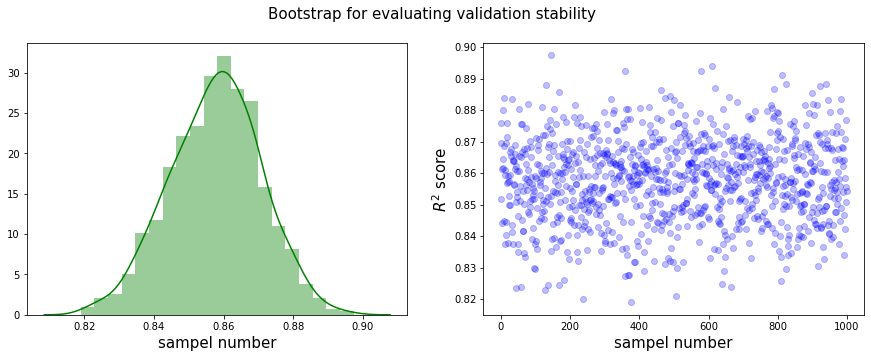

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

### Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [334]:
x_adv = pd.concat([
            train[numeric_features],
            test[numeric_features]]
        , axis=0)
x_adv = x_adv.reset_index(drop=True)
x_adv = x_adv.sample(frac=1)
y_adv = np.hstack((
            np.zeros(train.shape[0]),
            np.ones(test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [335]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv[numerical_features], y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [336]:
y_pred = model.predict_proba(train[numeric_features])

In [337]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]        0
(0.1, 0.2]        4
(0.2, 0.3]       12
(0.3, 0.4]       79
(0.4, 0.5]      578
(0.5, 0.6]    20850
(0.6, 0.7]    27973
(0.7, 0.8]      486
(0.8, 0.9]       19
(0.9, 1.0]        0
dtype: int64

In [338]:
y_pred_test = model.predict_proba(test[numeric_features])
pd.cut(
    y_pred_test[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]        0
(0.1, 0.2]        7
(0.2, 0.3]       36
(0.3, 0.4]      147
(0.4, 0.5]      888
(0.5, 0.6]    38197
(0.6, 0.7]    34939
(0.7, 0.8]      718
(0.8, 0.9]       68
(0.9, 1.0]        0
dtype: int64

In [339]:
train_AV = train[y_pred[:, 1] <= 0.6]
valid_AV = train[y_pred[:, 1] > 0.6]

In [340]:
model = xgb.XGBClassifier(n_estimators=100, n_jobs=8)
model.fit(train_AV[numerical_features],
            train_AV["isFraud"],
            eval_metric='auc',
            eval_set=eval_set,
            early_stopping_rounds=5)

[0]	validation_0-auc:0.78592	validation_1-auc:0.79849
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.80115	validation_1-auc:0.82460
[2]	validation_0-auc:0.79969	validation_1-auc:0.82579
[3]	validation_0-auc:0.81160	validation_1-auc:0.83337
[4]	validation_0-auc:0.83594	validation_1-auc:0.85549
[5]	validation_0-auc:0.85176	validation_1-auc:0.87271
[6]	validation_0-auc:0.84953	validation_1-auc:0.87326
[7]	validation_0-auc:0.86474	validation_1-auc:0.88312
[8]	validation_0-auc:0.87702	validation_1-auc:0.88226
[9]	validation_0-auc:0.87721	validation_1-auc:0.88965
[10]	validation_0-auc:0.88112	validation_1-auc:0.89270
[11]	validation_0-auc:0.88928	validation_1-auc:0.89924
[12]	validation_0-auc:0.89396	validation_1-auc:0.90419
[13]	validation_0-auc:0.89418	validation_1-auc:0.90687
[14]	validation_0-auc:0.89923	validation_1-auc:0.90516
[15]	validation_0-auc:0.89956

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [341]:
train_AV_pred = model.predict_proba(train_AV[numeric_features])
roc_auc_score(train_AV["isFraud"], train_AV_pred[:, 1])

0.9668245595459096

In [342]:
valid_AV_pred = model.predict_proba(valid_AV[numeric_features])
roc_auc_score(valid_AV["isFraud"], valid_AV_pred[:, 1])

0.8596990339016082

In [343]:
y_test_pred = model.predict_proba(X_test[numeric_features])
roc_auc_score(y_test, y_test_pred[:, 1])

0.8328569619784214

Чуть меньше переобучение, но и хуже результат на тестовой выборке. Думаю, что можно было бы как-то покрутить и получить более впечетляющий результат.

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [344]:
from sklearn.model_selection import StratifiedKFold

In [345]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [347]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train[numeric_features], train["isFraud"], model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.7396, valid-score = 0.6228
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.7357, valid-score = 0.6065
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.7338, valid-score = 0.6759
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.7357, valid-score = 0.6747
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.7266, valid-score = 0.522
CV-results train: 0.7343 +/- 0.004
CV-results valid: 0.6204 +/- 0.056
OOF-score = 0.6203


In [352]:
cv = cross_val_score(
    estimator=model, X=train[numerical_features], y=train["isFraud"], scoring="roc_auc", cv=5
)

print(cv)
print(f"CV-mean: {round(np.mean(cv), 4)}, CV-std: {round(np.std(cv), 4)}")

[0.86010404 0.87227026 0.87687664 0.79605008 0.87730025]
CV-mean: 0.8565, CV-std: 0.0309


Разброс валидации не очень большой (хотя на одном фолде 0.52 портит всю картину), так что в этом плане валидация не очень плохая.

### Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

In [354]:
train.sort_values("TransactionDT", inplace=True)
X_train = train.drop("isFraud", axis=1)
y_train = train["isFraud"]

In [355]:
test.sort_values("TransactionDT", inplace=True)
X_test = test.drop("isFraud", axis=1)
y_test = test["isFraud"]

In [356]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=42)

In [357]:
eval_set = [(X_valid[numerical_features], y_valid)]
model = xgb.XGBClassifier(n_estimators=100, n_jobs=8)

In [358]:
model.fit(X_train[numerical_features],
            y_train,
            eval_metric='auc',
            eval_set=eval_set,
            early_stopping_rounds=5)

[0]	validation_0-auc:0.74845
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.83951
[2]	validation_0-auc:0.83884
[3]	validation_0-auc:0.84197
[4]	validation_0-auc:0.84068
[5]	validation_0-auc:0.86289
[6]	validation_0-auc:0.86317
[7]	validation_0-auc:0.86624
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86961
[10]	validation_0-auc:0.86539
[11]	validation_0-auc:0.85550
[12]	validation_0-auc:0.86126
[13]	validation_0-auc:0.86669
[14]	validation_0-auc:0.87118
[15]	validation_0-auc:0.87264
[16]	validation_0-auc:0.87851
[17]	validation_0-auc:0.87957
[18]	validation_0-auc:0.87893
[19]	validation_0-auc:0.88055
[20]	validation_0-auc:0.88195
[21]	validation_0-auc:0.88368
[22]	validation_0-auc:0.88509
[23]	validation_0-auc:0.88501
[24]	validation_0-auc:0.88247
[25]	validation_0-auc:0.88366
[26]	validation_0-auc:0.88507
[27]	validation_0-auc:0.89031
[28]	validation_0-auc:0.89049
[29]	validation_0-auc:0.89279
[30]	validation_0-auc:0.89229
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [359]:
y_train_pred = model.predict_proba(X_train[numeric_features])
roc_auc_score(y_train, y_train_pred[:, 1])

0.9714793467055961

In [360]:
y_valid_pred = model.predict_proba(X_valid[numeric_features])
roc_auc_score(y_valid, y_valid_pred[:, 1])

0.892787381693249

In [361]:
y_test_pred = model.predict_proba(X_test[numeric_features])
roc_auc_score(y_test, y_test_pred[:, 1])

0.8510529116217853

In [362]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_valid, model.predict_proba(X_valid[numeric_features])[:, 1], roc_auc_score)

In [363]:
calculate_confidence_interval(scores)

(0.8726065897279157, 0.9116293977998501)

In [364]:
roc_auc_score(y_test, model.predict_proba(X_test[numeric_features])[:, 1])

0.8510529116217853

Итоговая метрика всё так же не вписывается в доверительный интервал. Больших различий использования разных переменных для проведения валидации я не вижу.